<a href="https://colab.research.google.com/github/fadhilahmad11/Machine-Learning/blob/main/06.%20Week%206/Data_Clustering_Online_Retail_W6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from google.colab import files
uploaded = files.upload()

df = pd.read_excel('Online Retail.xlsx')
display(df.head())
print(df.shape)

Saving Online Retail.xlsx to Online Retail (1).xlsx


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


(541909, 8)


In [3]:
df_clean = df.copy()
df_clean.dropna(subset=['CustomerID'], inplace=True)
df_clean['Description'] = df_clean['Description'].fillna('Unknown')
df_clean.drop_duplicates(subset=df_clean.columns.difference(['InvoiceNo']), keep='first', inplace=True)

df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
df_clean['Quantity'] = pd.to_numeric(df_clean['Quantity'], errors='coerce')
df_clean['UnitPrice'] = pd.to_numeric(df_clean['UnitPrice'], errors='coerce')
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean.dropna(subset=['Quantity', 'UnitPrice'], inplace=True)

In [15]:
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

summary = df_clean.groupby('CustomerID').agg(
    TotalSpend=('TotalAmount', 'sum'),
    InvoiceCount=('InvoiceNo', 'nunique')
)
summary['AvgOrderValue'] = summary['TotalSpend'] / summary['InvoiceCount']
summary['PurchaseFrequency'] = summary['InvoiceCount']

latest_date = df_clean['InvoiceDate'].max()
last_purchase = df_clean.groupby('CustomerID')['InvoiceDate'].max().reset_index()
last_purchase['Recency'] = (latest_date - last_purchase['InvoiceDate']).dt.days
summary = summary.merge(last_purchase[['CustomerID', 'Recency']], on='CustomerID')

features = ['TotalSpend', 'AvgOrderValue', 'PurchaseFrequency', 'Recency']
scaler = MinMaxScaler()
summary[features] = scaler.fit_transform(summary[features])
df_scaled = summary.reset_index()

display(df_scaled.head())

,index,CustomerID,TotalSpend,InvoiceCount,AvgOrderValue,PurchaseFrequency,Recency
0,0,12346,0.015109,2,0.408529,0.004049,0.871314
1,1,12347,0.030297,7,0.467194,0.024291,0.002681
2,2,12348,0.021442,4,0.451339,0.012146,0.198391
3,3,12349,0.021303,1,0.575989,0.000000,0.048257
4,4,12350,0.016288,1,0.440390,0.000000,0.828418


In [14]:
kmeans_model = KMeans(n_clusters=5, random_state=42)
df_scaled['kmeans_cluster'] = kmeans_model.fit_predict(df_scaled.drop(columns=['index', 'CustomerID']))

dbscan_model = DBSCAN(eps=0.2, min_samples=5)
df_scaled['dbscan_cluster'] = dbscan_model.fit_predict(df_scaled.drop(columns=['index', 'CustomerID']))

display(df_scaled.head())

,index,CustomerID,TotalSpend,InvoiceCount,AvgOrderValue,PurchaseFrequency,Recency,kmeans_cluster,dbscan_cluster
0,0,12346,0.015109,2,0.408529,0.004049,0.871314,0,0
1,1,12347,0.030297,7,0.467194,0.024291,0.002681,0,1
2,2,12348,0.021442,4,0.451339,0.012146,0.198391,0,2
3,3,12349,0.021303,1,0.575989,0.000000,0.048257,4,3
4,4,12350,0.016288,1,0.440390,0.000000,0.828418,4,3


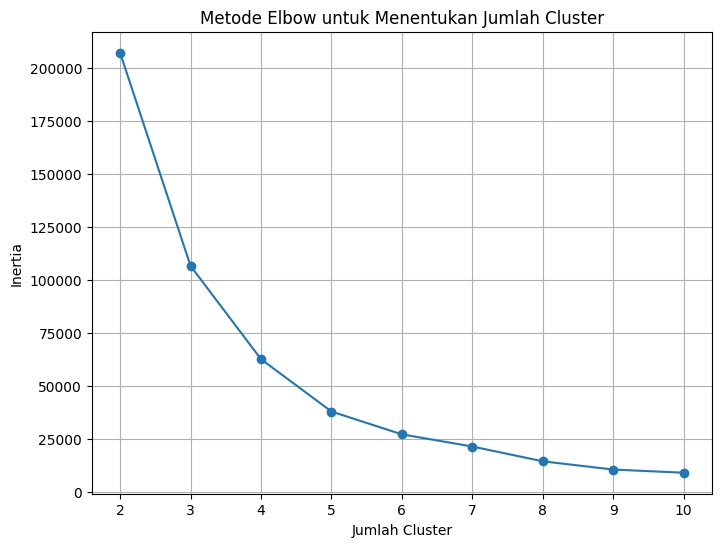

In [6]:
inertia_list = []
for k in range(2, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']))
    inertia_list.append(model.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia_list, marker='o')
plt.title('Metode Elbow untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [10]:
kmeans_sil = silhouette_score(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']), df_scaled['kmeans_cluster'])
dbscan_sil = silhouette_score(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']), df_scaled['dbscan_cluster'])

kmeans_cal = calinski_harabasz_score(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']), df_scaled['kmeans_cluster'])
dbscan_cal = calinski_harabasz_score(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']), df_scaled['dbscan_cluster'])

kmeans_dav = davies_bouldin_score(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']), df_scaled['kmeans_cluster'])
dbscan_dav = davies_bouldin_score(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']), df_scaled['dbscan_cluster'])

def hitung_dunn(data_array, label_array):
    n_clusters = len(np.unique(label_array))
    if n_clusters <= 1:
        return 0
    dist_matrix = squareform(pdist(data_array))
    min_inter = np.inf
    max_intra = 0

    for i in range(n_clusters):
        idx_i = label_array == i
        for j in range(i + 1, n_clusters):
            idx_j = label_array == j
            if np.any(idx_i) and np.any(idx_j):
                min_inter = min(min_inter, np.min(dist_matrix[np.ix_(idx_i, idx_j)]))
        if np.any(idx_i):
            max_intra = max(max_intra, np.max(dist_matrix[np.ix_(idx_i, idx_i)]))

    return min_inter / max_intra if not np.isinf(min_inter) else 0

kmeans_dunn = hitung_dunn(df_scaled.drop(columns=['index', 'CustomerID', 'dbscan_cluster']).values, df_scaled['kmeans_cluster'])
dbscan_dunn = hitung_dunn(df_scaled.drop(columns=['index', 'CustomerID', 'kmeans_cluster']).values, df_scaled['dbscan_cluster'])

evaluasi = pd.DataFrame({
    'Model': ['K-Means', 'DBSCAN'],
    'Silhouette': [kmeans_sil, dbscan_sil],
    'Calinski-Harabasz': [kmeans_cal, dbscan_cal],
    'Davies-Bouldin': [kmeans_dav, dbscan_dav],
    'Dunn': [kmeans_dunn, dbscan_dunn]
})

display(evaluasi)

,Model,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn
0,K-Means,0.716953,9984.006428,0.469543,0.028304
1,DBSCAN,0.892317,333.430807,0.812193,1.368443


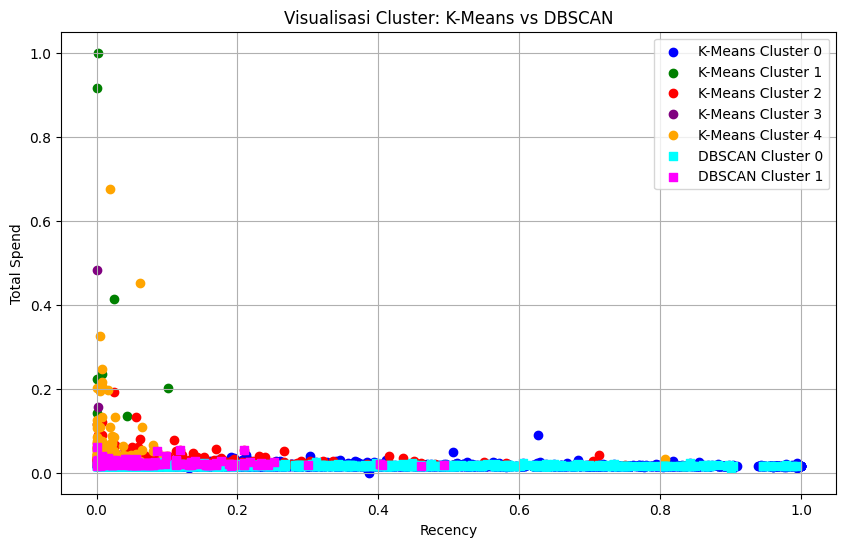

In [11]:
plt.figure(figsize=(10, 6))
colors = ['blue', 'green', 'red', 'purple', 'orange']
for i in range(5):
    plt.scatter(df_scaled[df_scaled['kmeans_cluster'] == i]['Recency'],
                df_scaled[df_scaled['kmeans_cluster'] == i]['TotalSpend'],
                label=f'K-Means Cluster {i}', color=colors[i], marker='o')

plt.scatter(df_scaled[df_scaled['dbscan_cluster'] == 0]['Recency'], df_scaled[df_scaled['dbscan_cluster'] == 0]['TotalSpend'],
            label='DBSCAN Cluster 0', color='cyan', marker='s')
plt.scatter(df_scaled[df_scaled['dbscan_cluster'] == 1]['Recency'], df_scaled[df_scaled['dbscan_cluster'] == 1]['TotalSpend'],
            label='DBSCAN Cluster 1', color='magenta', marker='s')

plt.xlabel('Recency')
plt.ylabel('Total Spend')
plt.title('Visualisasi Cluster: K-Means vs DBSCAN')
plt.legend()
plt.grid(True)
plt.show()

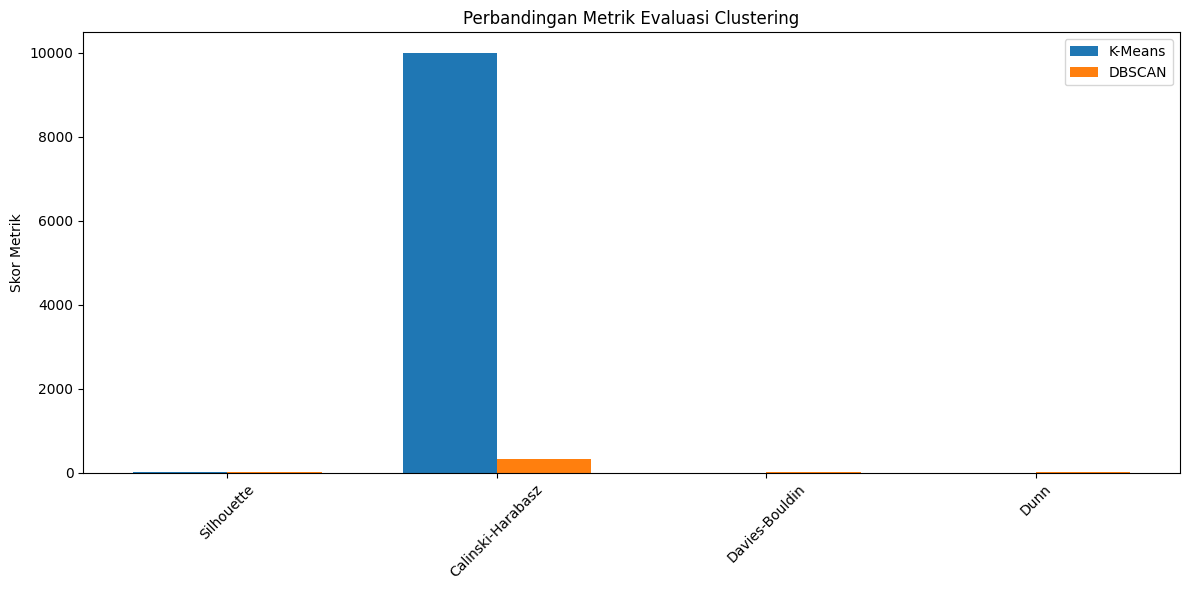

In [12]:
metrik = ['Silhouette', 'Calinski-Harabasz', 'Davies-Bouldin', 'Dunn']
x = np.arange(len(metrik))
bar_width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width / 2, evaluasi.loc[0, metrik], bar_width, label='K-Means')
plt.bar(x + bar_width / 2, evaluasi.loc[1, metrik], bar_width, label='DBSCAN')
plt.xticks(x, metrik, rotation=45)
plt.ylabel('Skor Metrik')
plt.title('Perbandingan Metrik Evaluasi Clustering')
plt.legend()
plt.tight_layout()
plt.show()

# **1. df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']**

Penjelasan: Persamaan ini menghitung total nilai transaksi untuk setiap baris dalam DataFrame df_clean.

Cara Kerja: Mengalikan nilai kolom 'Quantity' (jumlah barang) dengan nilai kolom 'UnitPrice' (harga satuan barang). Hasil perkalian tersebut disimpan dalam kolom baru bernama 'TotalAmount'.


# **2. summary['AvgOrderValue'] = summary['TotalSpend'] / summary['InvoiceCount']**

Penjelasan: Persamaan ini menghitung rata-rata nilai pesanan untuk setiap pelanggan.

Cara Kerja: Membagi total pengeluaran pelanggan (TotalSpend) dengan jumlah faktur/transaksi unik yang dilakukan oleh pelanggan tersebut (InvoiceCount). Hasil pembagian disimpan dalam kolom 'AvgOrderValue'.


# **3. last_purchase['Recency'] = (latest_date - last_purchase['InvoiceDate']).dt.days**

Penjelasan: Persamaan ini menghitung berapa hari yang lalu pelanggan terakhir melakukan pembelian (recency).

Cara Kerja: Mengurangi tanggal transaksi terakhir pelanggan (last_purchase['InvoiceDate']) dari tanggal transaksi terakhir secara keseluruhan (latest_date). Hasilnya adalah selisih waktu dalam bentuk timedelta, kemudian diambil atribut days untuk mendapatkan selisih dalam satuan hari. Hasilnya disimpan dalam kolom 'Recency'.


4. Fungsi hitung_dunn:

```
def hitung_dunn(data_array, label_array):
    n_clusters = len(np.unique(label_array))
    if n_clusters <= 1:
        return 0
    dist_matrix = squareform(pdist(data_array))
    min_inter = np.inf
    max_intra = 0

    for i in range(n_clusters):
        idx_i = label_array == i
        for j in range(i + 1, n_clusters):
            idx_j = label_array == j
            if np.any(idx_i) and np.any(idx_j):
                min_inter = min(min_inter, np.min(dist_matrix[np.ix_(idx_i, idx_j)]))
        if np.any(idx_i):
            max_intra = max(max_intra, np.max(dist_matrix[np.ix_(idx_i, idx_i)]))
            
    return min_inter / max_intra if not np.isinf(min_inter) else 0
```



*   Penjelasan: Fungsi ini menghitung Dunn Index, sebuah metrik untuk mengevaluasi kualitas klaster.
*   Cara Kerja:
- min_inter: Mencari jarak minimum antar klaster.
- max_intra: Mencari jarak maksimum dalam satu klaster.
- Dunn Index dihitung dengan rumus: min_inter / max_intra. Semakin tinggi nilainya, semakin baik kualitas klaster (klaster terpisah dengan baik dan padat).


# **Kesimpulan**

*   K-Means cocok untuk mengelompokkan data dengan distribusi cluster yang relatif bulat dan homogen.
*   DBSCAN unggul dalam mendeteksi noise dan bentuk cluster yang tidak teratur, serta menghasilkan hasil evaluasi metrik yang lebih baik secara keseluruhan.
*   Pemilihan algoritma tergantung pada konteks bisnis. Jika tujuannya mengelompokkan semua pelanggan secara rapi, K-Means lebih cocok. Namun jika ingin mendeteksi anomali atau pelanggan yang unik, DBSCAN lebih tepat.
